### Problem 4

We first implement an "coordinate descent" algorithm to iterative optimize $u$ and $v$.

Fix $v$, 
$$
u^{\text{opt}} = ((X^T X) \circ (v v^T) + \lambda I)^{-1} ((X^T Y)\circ v).
$$
Similarly, fix $u$, we have $v^{\text{opt}}$.

Iteratively optimizing gives the optimal solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
class doubleRidge:
    '''
    min u,v (y - x uv)^2 + lam (u^2 + v^2)
    '''
    def __init__(self, X, Y, lam):
        '''
        constructor
        '''
        self.x = X
        self.y = Y
        self.lam = lam 
        
    def obj(self, u, v):
        uv = u * v 
        res = self.x.dot(uv) - self.y 
        return res.dot(res) + self.lam*np.sum(u*u + v*v)
    
    def coodinateRidge(self, v):
        '''
        fix v, optimize u
        '''
        vm = v[:, np.newaxis]
        A = (self.x.T@self.x)*(vm@vm.T) + self.lam*np.eye(v.shape[0])
        return np.linalg.inv(A)@((self.x.T@self.y)*v)
    
    def solve(self, tol=1e-10):
        p = self.x.shape[1]
        
        u0 = np.ones(p)
        v0 = self.coodinateRidge(u0)
        fv = self.obj(u0, v0)
        
        u = self.coodinateRidge(v0)
        v = self.coodinateRidge(u)
        tmp = self.obj(u, v)
        
        while np.abs(tmp - fv) > tol:
            fv = tmp
            u = self.coodinateRidge(v)
            v = self.coodinateRidge(u)
            tmp = self.obj(u, v)
        return u, v

We use scikit-learn *diabetes* dataset to do the simulation.

In [3]:
from sklearn.linear_model import lasso_path
from sklearn import datasets

In [4]:
X, y = datasets.load_diabetes(return_X_y=True)
X /= X.std(axis=0)
n_samples = X.shape[0]

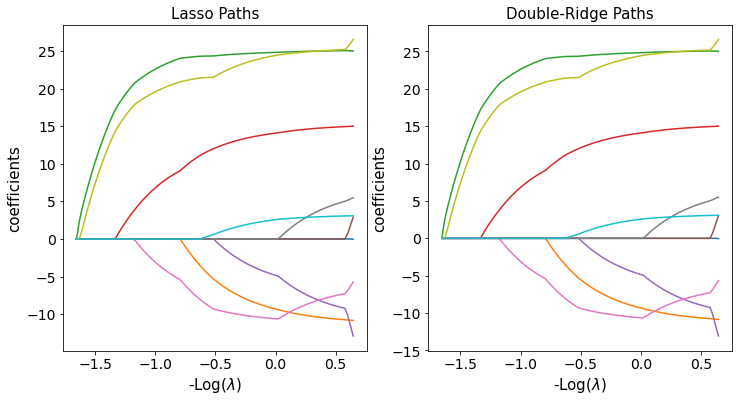

In [5]:
eps = 5e-3
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)
lams_lasso = alphas_lasso * n_samples
neg_log_alphas_lasso = -np.log10(alphas_lasso)

p, n = coefs_lasso.shape
coefs_dridge = np.zeros((n, p))
for (i,lam) in enumerate(lams_lasso):
    model = doubleRidge(X, y, lam)
    u, v = model.solve(tol=1e-7)
    coefs_dridge[i,:] = u*v

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(neg_log_alphas_lasso, coefs_lasso.T)
ax[0].set_xlabel("-Log($\\lambda$)", fontsize=15)
ax[0].set_ylabel("coefficients", fontsize=15)
ax[0].set_title("Lasso Paths", fontsize=15)
ax[0].tick_params(labelsize=14)

ax[1].plot(neg_log_alphas_lasso, coefs_dridge)
ax[1].set_xlabel("-Log($\\lambda$)", fontsize=15)
ax[1].set_ylabel("coefficients", fontsize=15)
ax[1].set_title("Double-Ridge Paths", fontsize=15)
ax[1].tick_params(labelsize=14)


plt.show()